# Discovery of the environment

In [1]:
import gymnasium as gym
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pkl
import sys
import text_flappy_bird_gym
import time

In [ ]:
if __name__ == '__main__':

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs = env.reset()

    # iterate
    while True:

        # Select next action
        action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

    env.close()


# Problem formulation

We work on the *TextFlappyBird-v0* version on the environnement. Hence the RL context is the following :
- observation state $(dx, dy)$ a tuple containing the horizontal and vertical distances (integers) to the next gap pipe. $dy \in [-15, 15]$ and $dx \in [0, 11]$
- action space $(Flap, Idle)$ two actions

Hence, our action-space state is quite small and discrete.

We will try :
- a Sarsa agent
- a Q-learning agent

With different rewards :
- +1 at each step and -10000 when dying
- score and -10000 when dying
- score + 1/distance and -10000 when dying

In [3]:
def create_q_values():
    
    Q = {}

    for dx in range(0, 14):
        Q[dx] = {}
        for dy in range(-15, 16):
            Q[dx][dy] = np.array([0., 0.])

    return Q

## Sarsa Agent

In [2]:
class ExpectedSarsaAgent():
    
    def agent_init(self, agent_init_info):
        """Setup for the agent
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            states_shape (tuple): The shape of the observation space,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.states_shape = agent_init_info["states_shape"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.epsilon_decay = agent_init_info["epsilon_decay"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = create_q_values()
    
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (tuple): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state[0][0]][state[0][1]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state[0][0]][state[0][1]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update
        self.q[self.prev_state[0][0]][self.prev_state[0][1]][self.prev_action] += self.step_size * (reward + self.discount * self.q[state[0][0]][state[0][1]][action] - self.q[self.prev_state[0][0]][self.prev_state[0][1]][self.prev_action])
        self.prev_state = state
        self.prev_action = action
        self.epsilon *= self.epsilon_decay
        
        return action
    
    def policy(self, state):
        """A step taken by the agent without updating action values
        Args:
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        # Choose action using epsilon greedy.
        current_q = self.q[state[0][0]][state[0][1]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        self.q[self.prev_state[0][0]][self.prev_state[0][1]][self.prev_action] += self.step_size * (reward - self.q[self.prev_state[0][0]][self.prev_state[0][1]][self.prev_action])
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

## Q-Learning Agent

In [52]:
class QLearningAgent():
    
    def agent_init(self, agent_init_info):
        """Setup for the agent
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            states_shape (tuple): The shape of the observation space,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.states_shape = agent_init_info["states_shape"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.epsilon_decay = agent_init_info["epsilon_decay"]
        self.start_decay = agent_init_info["start_decay"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = create_q_values()
    
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (tuple): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state[0][0]][state[0][1]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state[0][0]][state[0][1]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update
        self.q[self.prev_state[0][0]][self.prev_state[0][1]][self.prev_action] += self.step_size * (reward + self.discount * np.max(self.q[state[0][0]][state[0][1]]) - self.q[self.prev_state[0][0]][self.prev_state[0][1]][self.prev_action])
        self.prev_state = state
        self.prev_action = action
        
        return action
    
    def update_epislon(self, episodes):
        if episodes > self.start_decay:
            self.epsilon *= self.epsilon_decay

    def policy(self, state):
        """A step taken by the agent without updating action values
        Args:
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        # Choose action using epsilon greedy.
        current_q = self.q[state[0][0]][state[0][1]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        self.q[self.prev_state[0][0]][self.prev_state[0][1]][self.prev_action] += self.step_size * (reward - self.q[self.prev_state[0][0]][self.prev_state[0][1]][self.prev_action])
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

# Training

In [54]:
agent_type = "Q"
num_episodes = 50000
def train(agent_type = agent_type, num_episodes = num_episodes, epsilon = 0.01, step_size = 0.1, discount = 0.95, epsilon_decay = 1, start_decay = 20000):

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

    # setup agent
    if agent_type == "SARSA":
        agent = ExpectedSarsaAgent()
    elif agent_type == "Q":
        agent = QLearningAgent()
    agent.agent_init({"num_actions" : 2,
                    "states_shape" : (1, 1),
                    "epsilon" : epsilon,
                    "step_size" : step_size,
                    "discount" : discount,
                    "epsilon_decay" : epsilon_decay,
                    "start_decay" : start_decay,
                    "seed" : 0})

    scores = []
    count_success = 0

    for i in range(num_episodes):

        if i % 5000 == 0:
            print(i)

        # Initialize episode
        obs = env.reset()
        action = agent.agent_start(obs)
        done = False

        while not done:

            # Take step
            next_state, reward, done, _, info = env.step(action)
            next_obs = (next_state, info)
            next_action = agent.agent_step(reward, next_obs)

            # Update
            obs = next_obs
            action = next_action
        
        # Last update
        agent.agent_end(reward)
        scores.append(info['score'])
        agent.update_epislon(i)

        # if info['score'] > 500:
        #     count_success += 1
        #     if count_success >= 10:
        #         break
        # else:
        #     count_success = 0
    
    return agent, scores

In [6]:
agent, scores = train(agent_type = "SARSA", num_episodes = 50000)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000


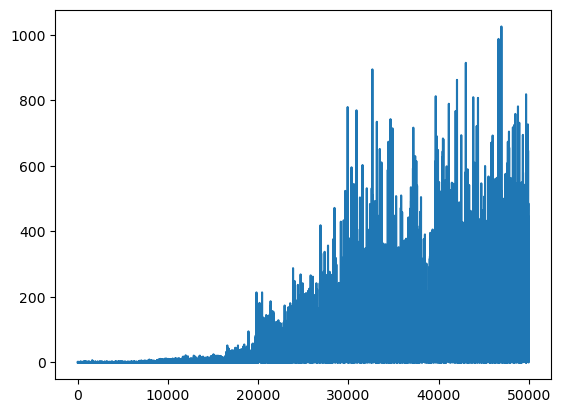

In [40]:
plt.plot(scores)

In [7]:
pkl.dump(agent, open('./agents/2/agent.pkl', 'wb'))

In [8]:
pkl.dump(scores, open('./agents/2/scores.pkl', 'wb'))

# Comparison of agents

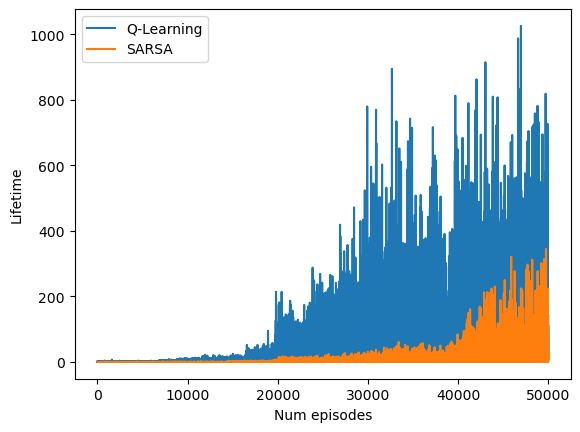

In [11]:
scores_SARSA = pkl.load(open('./agents/2/scores.pkl', 'rb'))
scores_Q = pkl.load(open('./agents/1/scores.pkl', 'rb'))

plt.plot(scores_Q, label = "Q-Learning")
plt.plot(scores_SARSA, label = "SARSA")

plt.legend()
plt.xlabel("Num episodes")
plt.ylabel("Lifetime")
plt.show()

# State-Value plot

In [22]:
agent_type = "Q"
num_episodes = 50000

[]

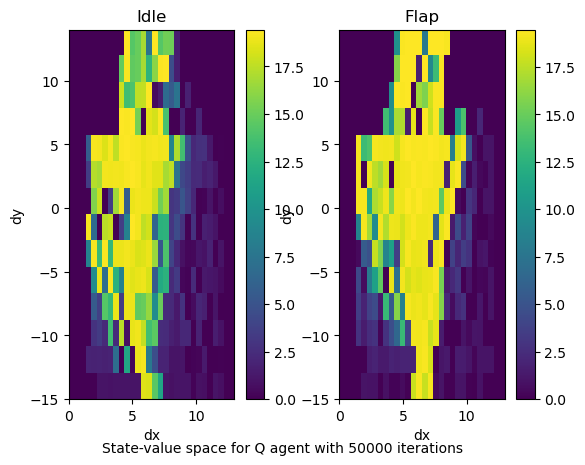

In [23]:
x = list(range(0, 14))
y = list(range(-15, 15))

# Idle
z1 = np.array([[agent.q[dx][dy][0] for dy in y] for dx in x])
# Flap
z2 = np.array([[agent.q[dx][dy][1] for dy in y] for dx in x])

x = np.array(x)
y = np.array(y)

fig, ax = plt.subplots(1, 2)

im1 = ax[0].imshow(z1, cmap='viridis', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
ax[0].set_title('Idle')
fig.colorbar(im1, ax = ax[0])

im2 = ax[1].imshow(z2, cmap='viridis', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
ax[1].set_title('Flap')
fig.colorbar(im2, ax = ax[1])

for i in range(2):
    ax[i].set_xlabel("dx")
    ax[i].set_ylabel("dy")

fig.text(x = 0.2, y = 0, s = f"\nState-value space for {agent_type} agent with {num_episodes} iterations")

plt.plot()

# Parameter sweep

To study how the agents behave when sweeping parameters ($\epsilon$, $\gamma$, $\alpha$), we need to define a relevant metric.
Since we can easily train a model that will never lose, the interesting aspect is more about the convergence speed.  
Thus, we will compare what is the average score on the last 100 games of the agent during is training, when training `50000` episodes.

## Epsilon greediness parameter

Let's see the influence of the degree of randomness in the $\epsilon$-greedy algorithm.

In [25]:
epsilons = [0.2, 0.1, 0.05, 0.02, 0.01, 0.005]
agents = []
scores_list = []
avg_perf_e = []

for epsilon in epsilons:

    print(f"Computing for epsilon = {epsilon}")

    #perf = []
    agent, scores = train(agent_type = "Q", num_episodes = 50000, epsilon = epsilon)
    avg_perf_e.append(scores[-100:])
    agents.append(agent)
    scores_list.append(scores)

    # avg_perf_e.append(np.array(perf).mean())

Computing for epsilon = 0.2
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for epsilon = 0.1
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for epsilon = 0.05
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for epsilon = 0.02
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for epsilon = 0.01
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for epsilon = 0.005
0
5000
10000
15000
20000
25000
30000
35000
40000
45000


In [32]:
[np.mean(np.array(perf)) for perf in avg_perf_e]

[4.5, 11.18, 25.21, 44.99, 12.8, 0.74]

Text(0.5, 1.0, 'Effect of epsilon on training')

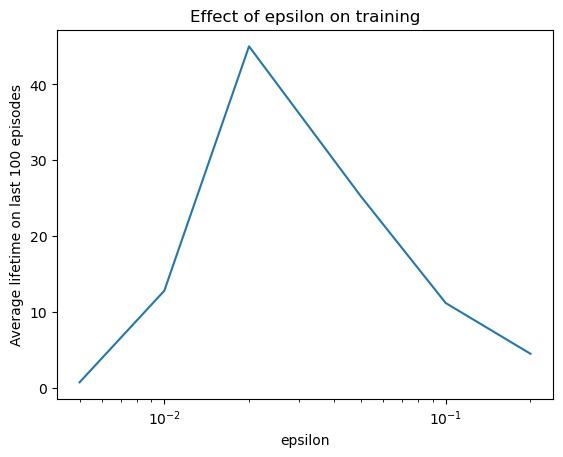

In [33]:
plt.plot(epsilons, [np.mean(np.array(perf)) for perf in avg_perf_e])
plt.xscale('log')
plt.xlabel("epsilon")
plt.ylabel("Average lifetime on last 100 episodes")
plt.title("Effect of epsilon on training")

## Discount factor influence

First, let's see the influence of the discount factor $\gamma$. Is a far or near-sighted policy the best ?

In [35]:
gammas = [0.8, 0.9, 0.95, 0.97, 0.99, 0.999]
avg_perf_g = []
perf = []
agents_d = []
scores_d = []


for gamma in gammas:

    print(f"Computing for gamma = {gamma}")

    agent, scores = train(num_episodes = 50000, epsilon = 0.02, discount = gamma)
    perf.append(scores[-100:])
    agents_d.append(agent)
    scores_d.append(scores)

    #avg_perf_g.append(np.array(perf).mean())

Computing for gamma = 0.8
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for gamma = 0.9
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for gamma = 0.95
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for gamma = 0.97
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for gamma = 0.99
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for gamma = 0.999
0
5000
10000
15000
20000
25000
30000
35000
40000
45000


Text(0.5, 1.0, 'Effect of discount factor on training')

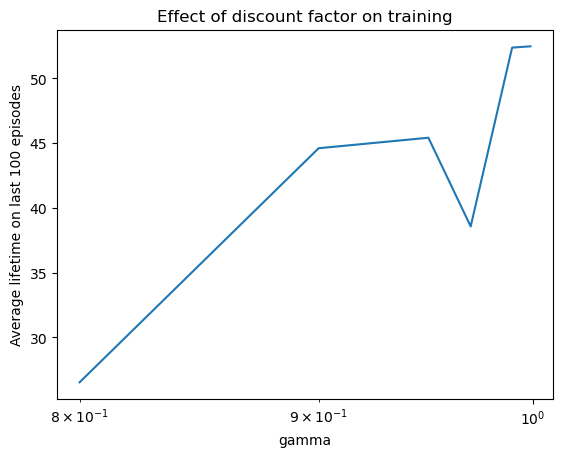

In [38]:
plt.plot(gammas, [np.mean(np.array(x)) for x in perf])
plt.xscale('log')
plt.xlabel("gamma")
plt.ylabel("Average lifetime on last 100 episodes")
plt.title("Effect of discount factor on training")

## Step size update

Let see the influence of changing the step size $\alpha$ on the convergence

In [41]:
alphas = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
perf_a = []
scores_a = []
agents_a = []

for alpha in alphas:

    print(f"Computing for alpha = {alpha}")

    agent, scores = train(num_episodes = 50000, 
                          epsilon = 0.02,
                           step_size = alpha,
                           discount = 0.999)
    perf_a.append(scores[-100:])
    agents_a.append(agent)
    scores_a.append(scores)
    


Computing for alpha = 0.5
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for alpha = 0.2
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for alpha = 0.1
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for alpha = 0.05
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for alpha = 0.02
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
Computing for alpha = 0.01
0
5000
10000
15000
20000
25000
30000
35000
40000
45000


Text(0.5, 1.0, 'Effect of step-size on training')

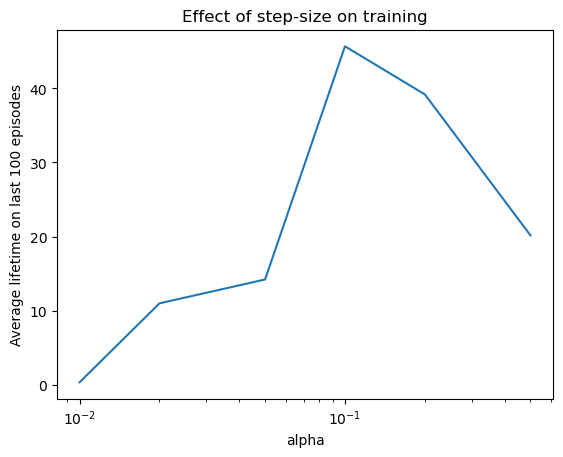

In [42]:
plt.plot(alphas, [np.mean(np.array(x)) for x in perf_a])
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("Average lifetime on last 100 episodes")
plt.title("Effect of step-size on training")

# Adding epsilon decay

What we notice, and what confirms the intuition, is that when the agent starts having very good scores, the only reason that it can lose is taking a random stupid action at the wrong time. To avoid that we can implement an epsilon decay.  
We implemented it in our agent and can compare the result of the agent with and without the decay.

In [55]:
_, scoreWithoutDecay = train(agent_type = "Q",
                          num_episodes = num_episodes,
                            epsilon = 0.02,
                            step_size = 0.1,
                             discount = 0.999)
agent, scoreWithDecay = train(agent_type = "Q",
                          num_episodes = num_episodes,
                            epsilon = 0.02,
                            step_size = 0.1,
                            discount = 0.999,
                            epsilon_decay = 0.9999)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000


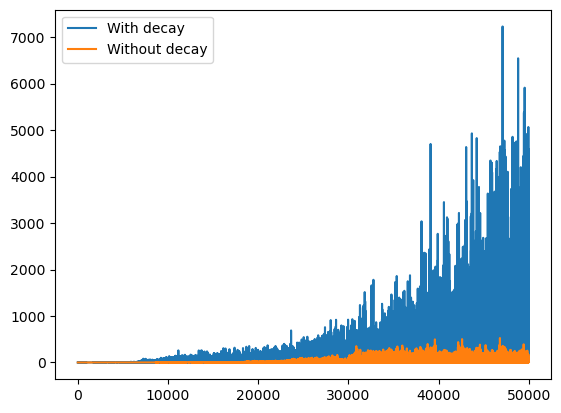

In [62]:
plt.plot(scoreWithDecay, label = "With decay")
plt.plot(scoreWithoutDecay, label = "Without decay")
plt.legend()

# Visualize agent

Here is a piece of code to visualize the behaviour of my agent in the environment.

In [63]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
state = env.reset()

# iterate
while True:

    clear_output(wait = True)

    # Select next action
    action = agent.policy(state) 

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)
    state = (obs, info)

    # Render the game
    sys.stdout.write(env.render())
    time.sleep(1/10) # FPS

    # If player is dead break
    if done:
        break

env.close()

Text Flappy Bird!
Score: 8
----------------------
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |   @     |       ]
[  |         |       ]
[                    ]
[                    ]
[                    ]
[                    ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=6,dy=-4)


KeyboardInterrupt: 

# Difference with screen-v0

In [25]:
# initiate environment
env = gym.make('TextFlappyBird-screen-v0', height = 15, width = 20, pipe_gap = 4)
state = env.reset()

# iterate
while True:

    clear_output(wait = True)

    # Select next action
    action = agent.policy(state) 

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)
    state = (obs, info)

    # Render the game
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

env.close()

TypeError: unhashable type: 'numpy.ndarray'

We cannot use the same agent since the observation space is not the same. Instead of observing only its own position, the agent visualizes the whole environment.
It is then required to train another agent taking into account this specificity. Having more information, this agent would then be better since it would be able to anticipate the next pipes.

# Original game

In [15]:
import time
import flappy_bird_gym
env = flappy_bird_gym.make("FlappyBird-v0")

obs = env.reset()
while True:
    # Next action:
    # (feed the observation to your agent here)
    action = agent.policy(obs) 

    # Processing:
    obs, reward, done, info = env.step(action)
    
    # Rendering the game:
    # (remove this two lines during training)
    env.render()
    time.sleep(1 / 30)  # FPS
    
    # Checking if the player is still alive
    if done:
        break

env.close()

IndexError: invalid index to scalar variable.

To implement our agent in this environment, we would need to apply a transformation to the observed state which is a couple of real coordinates to turn them as a couple of integers on the same scale as in `text-flappy-bird`